<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/24_5_Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Используя предложенный датасет произведений классической музыки, обучи модель "сочинять" музыку на произведениях только одного Шопена.
В качестве начальной последовательности для генерации используйте произведения Моцарта.
Для получения трех баллов достаточно получить ноты и аудиофайл с вашим сгенерированным произведением.
Хотите 4 балла? Добавьте в функцию генерации параметр temperature - температура модели. Температура модели влияет на генерацию. Более низкие температуры соответствуют более точному предсказанию, а более высокие температуры приводят к более случайной генерации.
Хотите 5 баллов? Используйте для обучения модели три переменные для представления ноты: pitch, step и duration. Высота звука (pitch) - это качество восприятия звука в виде номера ноты в формате MIDI. Шаг (step) - это время, прошедшее с предыдущей ноты или начала трека. Длительность (duration) - это продолжительность воспроизведения ноты в секундах и разница между временем окончания и началом ноты.

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install --upgrade music21
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore
!apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
from music21 import *

# настраиваем окружение в соответствии с документацией
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

In [ ]:
# Импортируем библиотеки
import tensorflow
import os
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import fluidsynth

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K
from keras.optimizers import Adamax

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "classical-music-midi" -d ./dataset
!dir ./dataset

--2024-10-22 06:31:59--  https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751606 (2.6M) [application/x-zip-compressed]
Saving to: ‘classical-music-midi.zip’

classical-music-mid 100%[===================>]   2.62M  2.15MB/s    in 1.2s    

2024-10-22 06:32:01 (2.15 MB/s) - ‘classical-music-midi.zip’ saved [2751606/2751606]

Albeniz    Borodin	Christmas  Granados  Mendelssohn  Rachmaninoff	Sinding
Bach	   Brahms	Clementi   Grieg     Moszkowski   Ravel		Tchaikovsky
Balakirev  Burgmueller	Debussy    Haydn     Mozart	  Schubert
Beethoven  Chopin	Godowsky   Liszt     Mussorgsky   Schumann


In [ ]:
CLASS_LIST=["Chopin"]

In [ ]:
all_midis = []
for compositor in CLASS_LIST:
    filepath = f"./dataset/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath+i

            # чтение и парсинг midi-файлов в Stream-объект библиотеки music21
            midi = converter.parse(tr)
            all_midis.append(midi)

In [ ]:
def getNotes(file):
    notes = []
    notes_to_parse = None
    for j in file:

        # получение инструментов из Stream-объекта
        songs = instrument.partitionByInstrument(j)

        # цикл по всем инструментам
        for part in songs.parts:
            # используем рекурсивный итератор в соответствии с документацией
            notes_to_parse = part.recurse()
            # части Stream-объекта, с которым мы работает состоит из разных элементов
            # отберем только интересующие нас элементы note.Note (нота) и chord.Chord (целый аккорд, последовательность нот)
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    # извлекаем ноту как тон (терминология библиотеки)
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    # аккорд функционирует как объект-нота, но имеет несколько последовательных тонов
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

In [ ]:
Corpus = getNotes(all_midis)
print("Всего нот во всех midi-файлах всего датасета:", len(Corpus))

Всего нот во всех midi-файлах всего датасета: 57894


In [ ]:
print("Первые 50 нот в корпусе:", Corpus[:50])

Первые 50 нот в корпусе: ['F3', 'F2', 'G3', 'G2', 'B-3', 'B-2', 'C#4', 'C#3', 'E3', 'E2', 'G3', 'G2', 'F3', 'F2', 'G3', 'G2', 'B-3', 'B-2', 'C#4', 'C#3', 'E3', 'E2', 'G3', 'G2', 'G3', 'G2', 'A3', 'A2', 'C4', 'C3', 'E-4', 'E-3', 'F#3', 'F#2', 'A3', 'A2', 'G3', 'G2', 'A3', 'A2', 'C4', 'C3', 'E-4', 'E-3', 'F#3', 'F#2', 'A3', 'A2', 'B-3', 'B-2']


In [ ]:
# Функция преобразования отрывка из корпуса обратно в поток
def chords_n_notes(chunk):
    Melody = []
    offset = 0 # счетчик
    for i in chunk:
        # Если это аккорд разделенный точкой
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") # Разделяем аккорд на части
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                # Преобразуем ноту в обект Note (нота)
                note_chunk = note.Note(inst_note)
                notes.append(note_chunk)
                # объединяем ноты в аккорды
                chord_chunk = chord.Chord(notes)
                # задаем позицию аккорда
                chord_chunk.offset = offset
                Melody.append(chord_chunk)
        # если это нота, а не аккорд
        else:
            # из текстового обозначения ноты делаем объект Note (ноту)
            note_chunk = note.Note(i)
            # задаем позицию ноты
            note_chunk.offset = offset
            Melody.append(note_chunk)
        # увеличиваем номер позиции
        offset += 1

    return Melody

# Преобразуем последовательность из 100 нот обратно в поток Stream
Music = chords_n_notes(Corpus[:100])
Melody_midi = stream.Stream(Music)

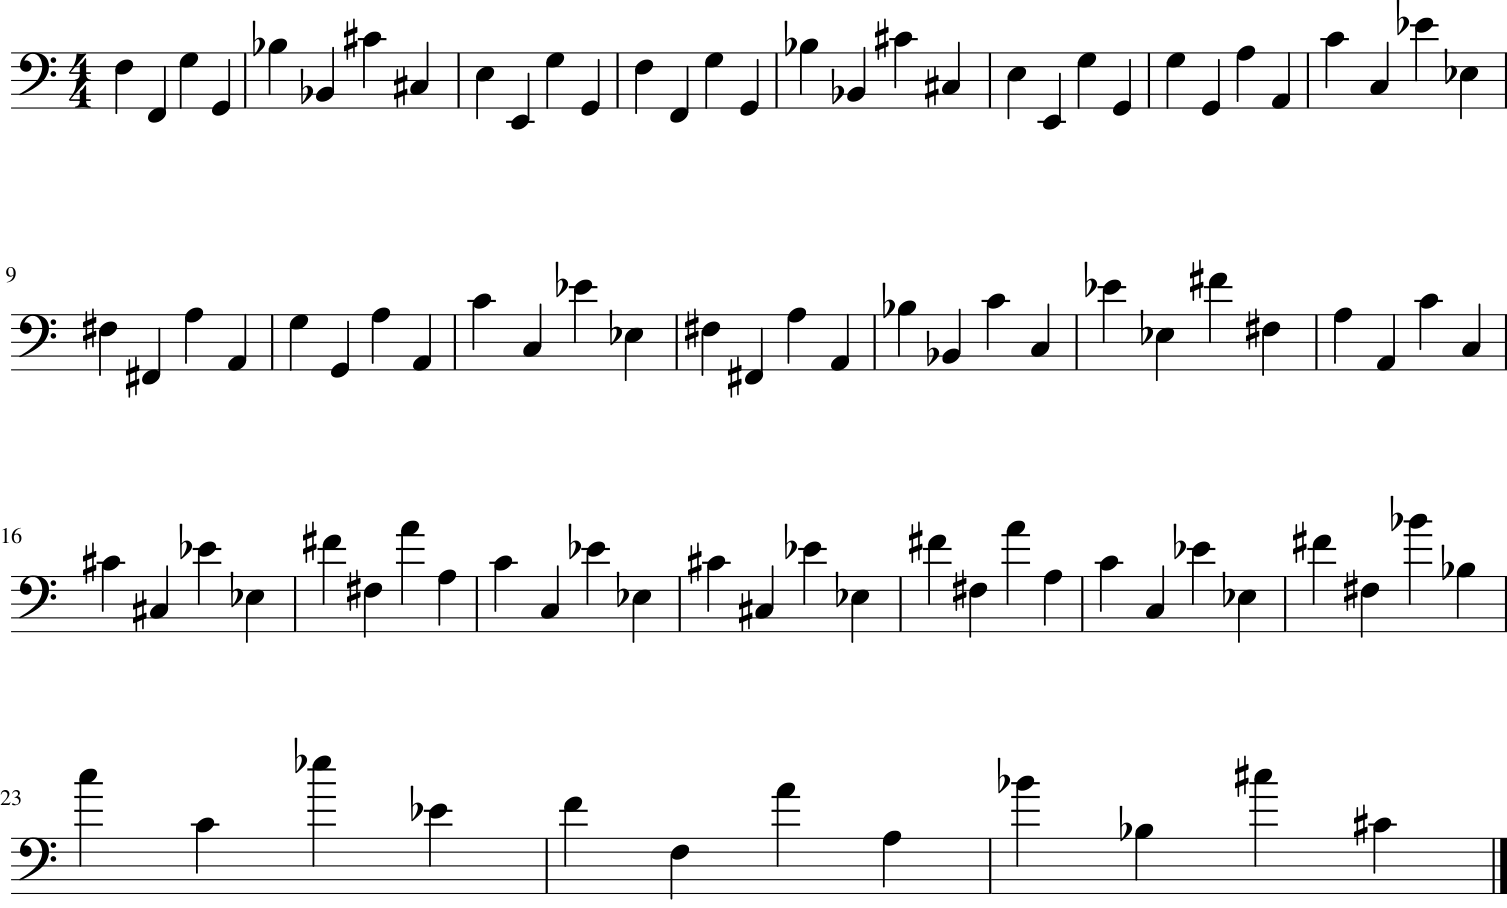

In [ ]:
# Отобразим нотный стан
Melody_midi.show()

In [ ]:
# Выведем в виде звуковой дорожки
Melody_midi.show('midi')